In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import  fisk
from sklearn.linear_model import LinearRegression
from sklearn.metrics import  r2_score
from scipy import integrate

In [109]:
df_population = pd.read_csv('population.csv')
df_population.set_index('year', inplace=True)
df_population = df_population.astype(float)

df_car_stock = pd.read_csv('stock_car.csv')
df_car_stock.set_index('year', inplace=True)
df_car_stock['total'] = df_car_stock.sum(axis=1)
df_car_stock = df_car_stock.astype(float)

df_params_gompertz = pd.read_csv('bootstrap_params.csv')
df_params_gompertz.set_index('index', inplace=True)

In [110]:
list_percentiles = [2.5, 50, 97.5]
pred_stock_total = {}

params_log = {}
for percentile in list_percentiles:
    df_params_log = pd.read_csv('pars_incomeDistribution_' + str(percentile) + '.csv')
    df_params_log.set_index('year', inplace=True)
    params_log[percentile] = {k: v for k, v in zip(df_params_log.index, df_params_log.values)}

def r_gompertz_function(x, a, b, r):
    return r * (np.exp(a * (np.exp(b * x))))


def log_logistic_distribution(x, a, b):
    return fisk.pdf(x, b, 0, a)


def car_stock(x, a, b, alpha, beta, r):
    return log_logistic_distribution(x, a, b) * r_gompertz_function(x, alpha, beta, r)


year_earliest = df_params_log.index[0]
year_start = df_car_stock.index[-1]
year_end = 2050

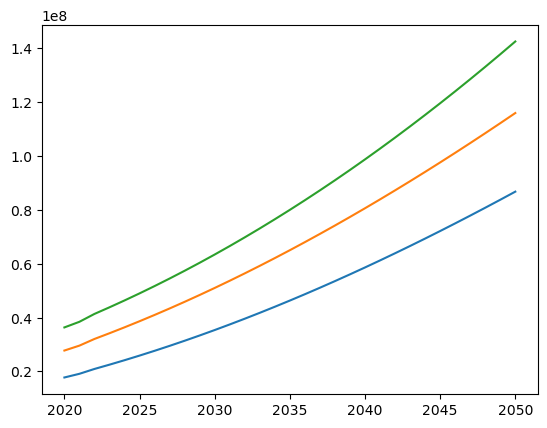

In [111]:
for percentile in list_percentiles:
    pred_stock = {}
    for year in range(year_earliest, year_end + 1):
        params = list(params_log[percentile][year]) + list(df_params_gompertz.loc[percentile])
        v, err = integrate.quad(car_stock, 0, np.inf, args=tuple(params))
        pred_stock[year] = v * df_population['population'][year]
    pred_filter_future = {k: v for k, v in pred_stock.items() if k >= year_start}
    plt.plot(pred_filter_future.keys(), pred_filter_future.values(), label=percentile)
    pred_stock_total[percentile] = pred_stock

In [112]:
pred_filter = {k: v for k, v in pred_stock_total[50.0].items() if k <= year_start}
r2 = r2_score(df_car_stock['total'].loc[year_earliest:year_start], list(pred_filter.values()))
print('Initial R-squared:', r2)

residual = sum(df_car_stock['total'].loc[year_earliest:year_start] - [round(pred_stock_total[50][year], 0) for year in range(year_earliest, year_start + 1)]) / (year_start - year_earliest + 1)
print('Residual:', residual)

for percentile in pred_stock_total.keys():
    for year in pred_stock_total[percentile].keys():
        pred_stock_total[percentile][year] += residual

pred_filter = {k: v for k, v in pred_stock_total[50.0].items() if k <= year_start}
r2 = r2_score(df_car_stock['total'].loc[year_earliest:year_start], list(pred_filter.values()))
print('Adjusted R-squared:', r2)

Initial R-squared: 0.5447644663256366
Residual: 6431761.80952381
Adjusted R-squared: 0.9386705326514937


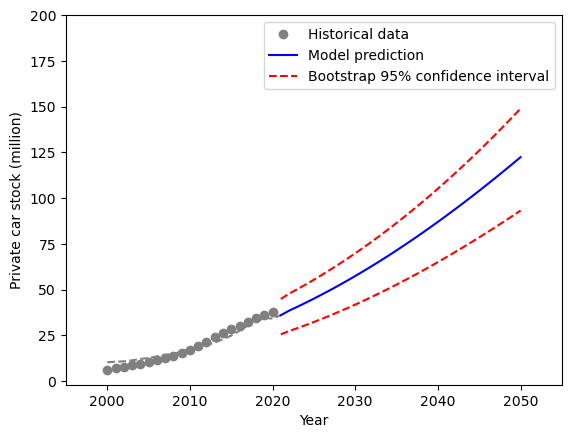

In [114]:
year_train = range(year_earliest, year_start + 1)
plt.plot(year_train, [df_car_stock['total'][year] / 10**6 for year in year_train], 'o', label='Historical data', color='gray')

year_hist = range(year_earliest, year_start + 2)
year_pred = range(year_start + 1, year_end + 1)

plt.plot(year_hist, [pred_stock_total[50][year] / 10**6for year in year_hist], '--', label=None, color='grey')
plt.plot(year_pred, [pred_stock_total[50][year] / 10**6 for year in year_pred], '-', label='Model prediction', color='blue')
plt.plot(year_pred, [pred_stock_total[2.5][year] / 10**6 for year in year_pred], '--r')
plt.plot(year_pred, [pred_stock_total[97.5][year] / 10**6 for year in year_pred], '--r', label='Bootstrap 95% confidence interval')

plt.xlabel('Year')
plt.ylabel('Private car stock (million)')

plt.xlim(1995, 2055)
plt.ylim(-2, 200)

plt.legend()
plt.show()
